# Sample Notebook

<p>Let's start here.  In Python, as in most programming languages, we have the ability to get very granualar in how we interact with the computer, but we can also stand on the shoulders of giants and reuse their work.  This is what we will opt to do as often as possible, other people have figured out the gory details of how to interpret the format of an Excel file so we don't have to - I'd rather depend on their work and focus on the real value add for our projects - that is spending time doing something with the data!</p>
<br/>
So the first thing we are going to do is ask Python to "load" up the code that knows how to read Exxcel files.  The code is stored in a "module" called pandas (keep in mind that case matters, so Pandas is not the same as pandas).  For simplicity we are going to ask Python to make the utilities in this module available to us whenever we specify the shortcut 'pd'.  (The pd shortcut is common for Pandas).  On to the first set of code.

In [ ]:
# Because we are using an on-line environment, we need an extra library.  If running locally, we can do this once and then never again
!pip install holidays

In [6]:
# Notice the '#' symbol?  This symbol tells Python that we don't want it to try to 'run' the code on this line of text
# This syntax is called a comment, and we can use it to clarify difficult code, or provide a hint as to what the next line (or several lines)
#  of code are meant to do

# Bring the Python module that can read Excel files into our scope so that we can use it, along with a few other helpful libraries
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib
import math
from scipy.stats import norm
from dateutil.parser import *
from datetime import *
from dateutil.rrule import *
import holidays


In [2]:
# The two key things that Pandas provides us is a Series datatype and a Dataframe.  A series is like a list of values that have an index like a number or
# a date value or a string.  A dataframe is a collection of Series all which share the same index.  So you can think of a dataframe type like a spreadsheet,
# just like when you open a spreadsheet and you see the row numbers on the left side and the column headers across the top, a pandas dataframe is similar
df = pd.read_csv('data/spy_012920.csv',index_col='Date', infer_datetime_format=True, parse_dates=True)
# The head function, lets use see the first few lines of the file we have loaded from the CSV file
print(df.shape)
df.head()

(1258, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-29,200.380005,202.300003,198.679993,201.990005,183.042038,173585400
2015-01-30,200.570007,202.169998,199.130005,199.449997,180.740311,197729700
2015-02-02,200.050003,202.029999,197.860001,201.919998,182.978622,163107000
2015-02-03,203.000000,204.850006,202.550003,204.839996,185.624680,124212900
2015-02-04,203.919998,205.380005,203.509995,204.059998,184.917847,134306700


# Plotting
Okay, we'll we have some data, now let's explore that data a bit.  It would be helpful to create a chart - yes?

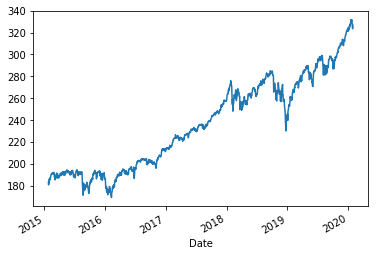

In [4]:
df['Adj Close'].plot();

# Column Calculations

Looking at a chart is great, but what if what we want isn't in the data, and we have to calculate it?  For instance, what if we were interested in the percent change daily?  One way to calculate this is

$\frac{(Close - Open)}{Open}*100\% = \%daily change$

In [ ]:
df['daily change pct'] = ((df['Close']-df['Open'])/df['Open'])*100
df.head()

## Determining the number of up days versus down

Just looking at the data, it seems that it would be interesting to know how many days the stock went up vs going down, so we can apply an *aggregate* function to a column of data as well.  Let's count ups and downs.


In [ ]:
# This first statement creates a boolean series with True in every row where the condition is satisfied and False otherwise.
updays_filter = df['daily change pct'] > 0
print(updays_filter.head())
# Then we can use this filter (also called a boolean mask) to select just the rows we are interested in and apply our aggregate function these rows
print(df.loc[updays_filter].count())

# This is helpful, but I don't need to see the same count for all of the columns, maybe just one?
updays = df.loc[updays_filter, 'daily change pct'].count()
print(f'\nJust the up days please: {updays}')

# That's better.  No about the down days.  We can certainly just reverse the equation like so
downdays_filter = df['daily change pct'] < 0

# But there is even a better way.  The tilde symbol (~) says to apply the boolean opposite to the series, so that True's become False
downdays_filter = ~updays_filter
downdays = df.loc[downdays_filter,'daily change pct'].count()


print(f'\n\nUpdays {updays}.  Downdays: {downdays}')

## Rolling Windows

Of course, we have the ability to apply all manner of aggregate functions (that is, functions that take a list of numbers and calculate a single result) such as mean, median, count, sum, std, var etc.  But often times we want not to work with the entire dataset, but just a portion of the window.  For instance, we want to know the 30-day moving average of the stock close price.  Pandas allows us this with the "rolling" function.

In [ ]:
df['30DMA'] = df['Close'].rolling(30).mean()


# Let's plot it along with the close price but on two separate figures
df[['30DMA','Close']].plot(subplots=True, figsize=(6,6));

In [ ]:
# Let's add in the 200 day moving average as well and then plot them together
df['200DMA'] = df['Close'].rolling(200).mean()

df[['30DMA','200DMA']].plot(figsize=(6,6));

In [ ]:
# In order to get the last say 100 days, we need to get an offset of days

TODAY = pd.datetime.today()
offset = pd.Timedelta(days=100)
last_100 = df[TODAY-offset:]
last_100

In [ ]:
# Or if we want a specific timeframe like this year
df.loc['2020']

In [ ]:
# Or maybe we want everything from Dec 2019 til now
df['12-2019':]

# Black-Sholes Calculations

The Black-Sholes pricing model can be calculated using the _current price_, _strike price_, _volatility_, _risk free rate_, and the _expiration_.  Two approaches are outlined here - first given a specific date, we can parse and figure out the number of days.  The second takes the number of days directly.

In [19]:
def BlackSholes(currentPrice, strikePrice, volatility, rate, expiration = '12/31/2020'):
    if type(expiration) is str:
        expiration = parse(expiration)
    term = (expiration.date() - date.today()).days
    return _BlackSholes(currentPrice,strikePrice,volatility,rate, term, termUnits='days')

def _BlackSholes(currentPrice, strikePrice, volatility, rate, term, termUnits='days'):
    # this is the log of the current price / strike price term
    logStockStrike = math.log(currentPrice/strikePrice)
    # represents the sigma-squared divided by 2 term
    sigmaDiv2 = (volatility**2)/2
    # Convert days to part of years
    T = term/365 if termUnits == 'days' else term
    ert = math.exp(-rate*T)

    d1 = (logStockStrike + (rate+sigmaDiv2)*T) / (volatility*math.sqrt(T))
    d2 = d1 - volatility*math.sqrt(T)
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    callPrice = currentPrice*Nd1 - strikePrice*ert*Nd2

    Nnegd1 = norm.cdf(-d1)
    Nnegd2 = norm.cdf(-d2)
    putPrice = strikePrice*ert*Nnegd2 - currentPrice*Nnegd1

    return (callPrice, putPrice)


In [20]:
# Notice when we call this function, that both the Call Price and the Put Price are returned
currentPrice = 333.45
volatility = 0.125
strikePrice = 340
riskFreeRate = 0.017
expiration = '12/31/2020'

callPrice, putPrice = BlackSholes(currentPrice, strikePrice, volatility, riskFreeRate, expiration)
print(f'Call Price: {callPrice:0.2f}')
print(f'Put Price: {putPrice:0.2f}')

Call Price: 14.59
Put Price: 16.24


In [21]:
# If we wanted to try a number of volatilities we could just as easily put these in an array and then call them 
options_12_20 = pd.DataFrame({'vol':np.arange(0.12,0.20,0.01)})
options_12_20['bs'] = options_12_20['vol'].apply(lambda x: BlackSholes(currentPrice, strikePrice, x, riskFreeRate,expiration))

# Just a bit of magic to get the values returned from a tuple into two columns
options_12_20[['call', 'put']] = pd.DataFrame(options_12_20['bs'].tolist(), index=options_12_20.index)
options_12_20.drop(columns='bs',inplace=True)
options_12_20['actual call'] = 14.69
options_12_20['actual put'] = 21.80

options_12_20

,vol,call,put,actual call,actual put
0,0.12,13.979707,15.624720,14.69,21.8
1,0.13,15.209467,16.854480,14.69,21.8
2,0.14,16.439046,18.084058,14.69,21.8
3,0.15,17.668383,19.313396,14.69,21.8
4,0.16,18.897431,20.542443,14.69,21.8
5,0.17,20.126144,21.771156,14.69,21.8
6,0.18,21.354481,22.999494,14.69,21.8
7,0.19,22.582406,24.227419,14.69,21.8
8,0.20,23.809883,25.454896,14.69,21.8


In [ ]:
# and then we already know how to plot
options_12_20.plot(x='vol');

# Okay, time to get a bit more clever

We can do something called multi-level indexing.  In other words, we might want to get the put and call prices for a range of dates and volatilities rather than just just a single day.  We can also calculate the prices a number of different strike prices, then we'll have a whole slew of data to pick from.

So we start by creating a list of dates when the options expire.  For SPY this means every Mon-Wed-Fri, for other stocks it's usually every Friday for the next 6 weeks then the third Friday of the month.  For our purposes we are just going to look at options that expire on monthly cycles for the next 12 months.  Keep in mind that we have to take into account holidays, so if the Friday expiration falls on a holiday, then it expires on Thursday.

For this handy little bit of help, we are going to use [dateutil](https://dateutil.readthedocs.io/en/stable/) and also we want to handle holidays so we'll depend on [holidays](https://pypi.org/project/holidays/).  We've got the handy library dateutil to allows us to do timemath relatively easily (that is calculate the 3rd Friday of the month for the next 12 months).  Then we'll make sure that these days don't fall on a holiday, in which case, we need to expire on Thursday instead.

In [64]:
# Start with figuring out the options dates (this says, starting today, give me every 3rd Friday of the month for a year)
expiration_dates = [dt.date() for dt in rrule(MONTHLY, count=12, byweekday=FR(3))]
us_holidays = holidays.UnitedStates()
expiration_dates = [x-timedelta(-1) if x else x in us_holidays for x in expiration_dates]

# Now, give me a range of volatilities the first parameter is start, second is end, third is step
# due to a "bug" in numpy's range function, I have to first move by ints then divide by 100
volatilities = np.arange(12,20) * 0.01

# And if we like we can also add strike prices, let's start with the stock's current price and give ourselves 10 options
# in either direction, in 2.50 increments rounded to the nearest $2.50 above or below the price...  
# So for the case where a stock is $86, we'll start going down from $85, $82.50.... and up from $85
strike_midpoint=2.5 * round(currentPrice/2.5)
strike_range = np.arange(strike_midpoint-25,strike_midpoint+25,2.5)

indexes = pd.MultiIndex.from_product([expiration_dates,strike_range, volatilities],names=['Expiration', 'Strike','Volatility'])
df_options = pd.DataFrame(index=indexes)
df_options.reset_index(inplace=True)
df_options.head()


,Expiration,Strike,Volatility
0,2020-03-21,307.5,0.12
1,2020-03-21,307.5,0.13
2,2020-03-21,307.5,0.14
3,2020-03-21,307.5,0.15
4,2020-03-21,307.5,0.16


## Calculating values

Now we need to go through the effort to calculate BS prices for each of these three variables strike price, expiration, and volatility.  We want to do what we did before with the getting the call prices and put prices so that we can determine which ones make the most sense to us.


In [65]:
# This code says..  for every row in the data, apply the BlackSholes function with the Strike, Volatility, and Expiration
# the results should be put into two columns called Call and Put upon the return
df_options[['Call','Put']] = df_options.apply(lambda x: BlackSholes(currentPrice, 
                                                          x['Strike'], 
                                                          x['Volatility'], 
                                                          riskFreeRate, 
                                                          x['Expiration']),
                                              axis=1, result_type='expand')

# And just so that we are back where we started, let's recreate our multi-index
df_options['Expiration'] = pd.to_datetime(df_options['Expiration'])
df_options.set_index(['Expiration', 'Strike', 'Volatility'], inplace=True)
df_options.head()

Call       Put
Expiration Strike Volatility                     
2020-03-21 307.5  0.12        26.356063  0.019614
                  0.13        26.374715  0.038266
                  0.14        26.402978  0.066529
                  0.15        26.442416  0.105967
                  0.16        26.494134  0.157685

In [66]:
# Now we can do business on our dataframe, let's say we want to look at all the prices for the May expiration
df_options.loc[('05-2020')]

Call        Put
Expiration Strike Volatility                      
2020-05-16 307.5  0.12        27.692877   0.556453
                  0.13        27.913237   0.776812
                  0.14        28.167879   1.031454
                  0.15        28.453767   1.317343
                  0.16        28.767855   1.631430
                  0.17        29.107243   1.970819
                  0.18        29.469265   2.332841
                  0.19        29.851510   2.715085
           310.0  0.12        25.410142   0.764072
                  0.13        25.676131   1.030061
                  0.14        25.975547   1.329477
                  0.15        26.304715   1.658645
                  0.16        26.660225   2.014154
                  0.17        27.039002   2.392932
                  0.18        27.438325   2.792255
                  0.19        27.855806   3.209736
           312.5  0.12        23.186568   1.030852
                  0.13        23.501381   1.345665
                  0.14        23.847545   1.691829
                  0.15        24.221030   2.065314
                  0.16        24.618292   2.462576
                  0.17        25.036265   2.880549
                  0.18        25.472313   3.316597
                  0.19        25.924179   3.768463
           315.0  0.12        21.032831   1.367469
                  0.13        21.398331   1.732969
                  0.14        21.791990   2.126628
                  0.15        22.209731   2.544369
                  0.16        22.648115   2.982754
                  0.17        23.104258   3.438897
...                                 ...        ...
           347.5  0.14         4.077530  16.786774
                  0.15         4.635458  17.344702
                  0.16         5.203646  17.912890
                  0.17         5.780413  18.489657
                  0.18         6.364417  19.073661
                  0.19         6.954573  19.663816
           350.0  0.12         2.433053  17.632651
                  0.13         2.923094  18.122693
                  0.14         3.433085  18.632683
                  0.15         3.959610  19.159208
                  0.16         4.499954  19.699552
                  0.17         5.051941  20.251539
                  0.18         5.613810  20.813408
                  0.19         6.184127  21.383725
           352.5  0.12         1.954035  19.643987
                  0.13         2.400580  20.090533
                  0.14         2.871748  20.561701
                  0.15         3.363584  21.053536
                  0.16         3.872871  21.562823
                  0.17         4.396984  22.086936
                  0.18         4.933771  22.623724
                  0.19         5.481459  23.171412
           355.0  0.12         1.554778  21.735085
                  0.13         1.956257  22.136564
                  0.14         2.386569  22.566875
                  0.15         2.841429  23.021735
                  0.16         3.317258  23.497564
                  0.17         3.811072  23.991379
                  0.18         4.320384  24.500691
                  0.19         4.843114  25.023420

[160 rows x 2 columns]

In [67]:
# Or what if we only want the values in May 2020 that have a strike of 352.5
df_options.loc[('5-2020',352.5),]

Call        Put
Expiration Strike Volatility                     
2020-05-16 352.5  0.12        1.954035  19.643987
                  0.13        2.400580  20.090533
                  0.14        2.871748  20.561701
                  0.15        3.363584  21.053536
                  0.16        3.872871  21.562823
                  0.17        4.396984  22.086936
                  0.18        4.933771  22.623724
                  0.19        5.481459  23.171412

In [76]:
# We can also look at all the options with a volatility that we believe in
df_options.xs(0.16,axis=0,level=2, drop_level=False)

Call        Put
Expiration Strike Volatility                      
2020-03-21 307.5  0.16        26.494134   0.157685
           310.0  0.16        24.092403   0.252812
           312.5  0.16        21.735678   0.392946
           315.0  0.16        19.438736   0.592862
           317.5  0.16        17.218418   0.869402
           320.0  0.16        15.092945   1.240787
           322.5  0.16        13.080939   1.725639
           325.0  0.16        11.200231   2.341789
           327.5  0.16         9.466586   3.105003
           330.0  0.16         7.892508   4.027782
           332.5  0.16         6.486255   5.118388
           335.0  0.16         5.251229   6.380219
           337.5  0.16         4.185777   7.811626
           340.0  0.16         3.283451   9.406159
           342.5  0.16         2.533645  11.153210
           345.0  0.16         1.922526  13.038949
           347.5  0.16         1.434131  15.047413
           350.0  0.16         1.051480  17.161619
           352.5  0.16         0.757596  19.364594
           355.0  0.16         0.536354  21.640210
2020-04-18 307.5  0.16        27.556361   0.819664
           310.0  0.16        25.326900   1.083807
           312.5  0.16        23.161520   1.412031
           315.0  0.16        21.069585   1.813700
           317.5  0.16        19.060363   2.298082
           320.0  0.16        17.142707   2.874030
           322.5  0.16        15.324732   3.549659
           325.0  0.16        13.613511   4.332042
           327.5  0.16        12.014805   5.226940
           330.0  0.16        10.532842   6.238581
...                                 ...        ...
2021-01-16 332.5  0.16        23.114064  17.123159
           335.0  0.16        21.864384  18.335578
           337.5  0.16        20.663023  19.596315
           340.0  0.16        19.509551  20.904941
           342.5  0.16        18.403434  22.260923
           345.0  0.16        17.344039  23.663627
           347.5  0.16        16.330639  25.112325
           350.0  0.16        15.362419  26.606204
           352.5  0.16        14.438488  28.144371
           355.0  0.16        13.557879  29.725861
2021-02-20 307.5  0.16        39.447312   8.342158
           310.0  0.16        37.740322   9.093255
           312.5  0.16        36.077425   9.888447
           315.0  0.16        34.459289  10.728399
           317.5  0.16        32.886472  11.613670
           320.0  0.16        31.359423  12.544709
           322.5  0.16        29.878478  13.521853
           325.0  0.16        28.443864  14.545327
           327.5  0.16        27.055697  15.615248
           330.0  0.16        25.713985  16.731624
           332.5  0.16        24.418629  17.894356
           335.0  0.16        23.169430  19.103245
           337.5  0.16        21.966087  20.357990
           340.0  0.16        20.808205  21.658197
           342.5  0.16        19.695300  23.003379
           345.0  0.16        18.626800  24.392968
           347.5  0.16        17.602055  25.826311
           350.0  0.16        16.620340  27.302684
           352.5  0.16        15.680862  28.821294
           355.0  0.16        14.782764  30.381285

[240 rows x 2 columns]